# Bloch Simulation to Find Ideal Inversion Time

***
### 1) Import functions and libraries 

To start with, we can just import the functions we will be using later, as well as some useful fixed parameters.

In [1]:
from funcs import *
from matplotlib import animation, rcParams
from IPython.display import HTML
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
%matplotlib inline



***
### 2) Choose the simulation parameters, and simulate the buildup to the steady state

Now you can choose some of the parameters that will affect your simulation results. These will depend on:
- $T_1$
- $T_2$
- $\alpha$
- $TR$



In [2]:
### Experimental parameters
gamma_bar = 42.58e6 # Gamma bar in Hz/T
t_res = 5e-4 # Frame rate of simulation in seconds
T1 = 800e-3 # % T1 in seconds 
T2 = 70e-3 # T2 in seconds 
alpha_s = 10 # Flip angle of the RF pulse in degrees
alpha_l = 180
t_rf = 1e-3 # duration of the RF pulse in seconds
t_tr_short = 4e-3 # duration of the TR in seconds
t_tr_long = 800e-3
t_i = 420e-3
n_s = 28952
ns_per = 75

Next we will setup some of the necessary parameters for the simulation, based on what has been requested

In [3]:
### Visualisation parameters 
noTRvis = 1 # How many TRs to visualise?
npts_rf=np.rint(t_rf/t_res).astype(np.int32) # Calculated number of frames to visualise full RF pulse
npts_tr_long=np.rint(t_tr_long/t_res).astype(np.int32) # Calculated number of frames to visualise full RF pulse
npts_tr_short=np.rint(t_tr_short/t_res).astype(np.int32) # Calculated number of frames to visualise full RF pulse
print(npts_tr_long)
print(npts_tr_short)
print(npts_rf)

### Calculations 
# B1 strength we need for flip angle given chosen RF pulse duration 
B1_l = np.deg2rad(alpha_l) / (2*np.pi*gamma_bar*t_rf) 
B1_s = np.deg2rad(alpha_s) / (2*np.pi*gamma_bar*t_rf) 
dB0 = np.array([0])

# Sequence of RF phases to give N periodic behaviour
phi_array = np.zeros(noTRvis)


1600
8
2


Now we can define our pulse sequence as a series of blocks. Each block occurs sequentially for a defined period of time, during which the B1 magnitude and phase are set to a chosen value.

Finally, we can run the Bloch simulation given the pulse sequence defined above

***
## 3) Visualise the magnetisation behaviour over successive TRs in the steady state

Now we will visualise the magnetisation behaviour across successive TRs while in the steady state. To do this, we split up the sequence timing blocks to agree with the temporal resolution we have chosen for visualisation.

1600
Simulating TRs for visualisation...
(1600, 3)


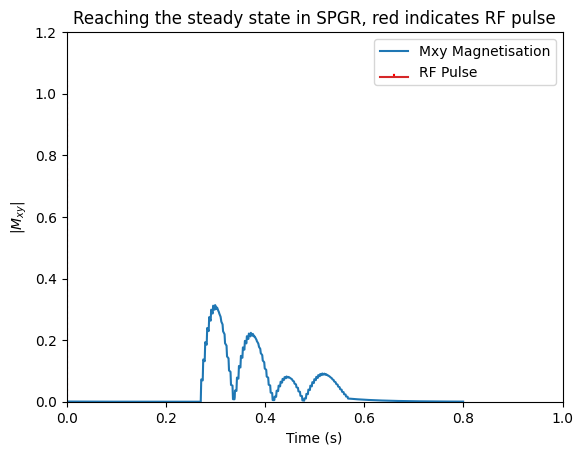

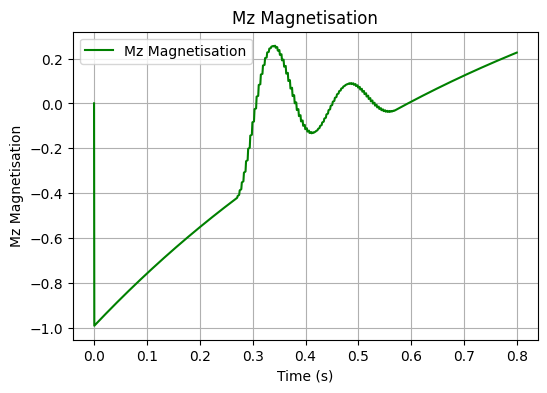

In [11]:
fig = plt.figure()
### Pulse sequence expressed as a series of blocks, with timings, |B1|, B1 phase 
### Setup equilibrium magnetisation vectors for all isochromats
M0 = np.array([0.,0.,1]) # Starting again with M in the +z direction
#global M
M=np.tile(M0.reshape(3,1),(1,np.size(dB0))) # Our M vector is now 4D.: 3D vector + dB0 

lengt = noTRvis * npts_tr_long
print(lengt)
t_events = np.zeros([lengt,3])  # Setup empty array of instructions, split into frames*noTRvis blocks
M_measured = np.zeros([lengt,3]) # Setup empty array of measured Magnetisation
time_blocks = np.ones(lengt)*t_res  # Setup timing of events
phi_blocks = []
rf_blocks = []

wait_ti = t_i - (t_tr_short*ns_per/2)
interval = int(wait_ti/t_res)

starting_len = ((npts_rf + interval)+ ns_per*(npts_tr_short))

for idx in range(noTRvis,0,-1):   
    rf_blocks = np.append(rf_blocks,np.repeat(B1_l,npts_rf))                # RF ON FOR A PERIOD         
    phi_blocks = np.append(phi_blocks,np.zeros(npts_rf))                # WITH PHASE PHI
    rf_blocks = np.append(rf_blocks,np.zeros(interval))            # RF THEN OFF DURING THE TR
    phi_blocks = np.append(phi_blocks,np.zeros(interval))          # WITH ZERO PHASE

    for tr_s in range (ns_per,0,-1):
        rf_blocks = np.append(rf_blocks,np.repeat(B1_s,npts_rf))                # RF ON FOR A PERIOD         
        phi_blocks = np.append(phi_blocks,np.repeat(phi_array[-idx],npts_rf)) # WITH PHASE PHI
        rf_blocks = np.append(rf_blocks,np.zeros(npts_tr_short-npts_rf))            # RF THEN OFF DURING THE TR
        phi_blocks = np.append(phi_blocks,np.zeros(npts_tr_short-npts_rf))  

    rf_blocks = np.append(rf_blocks,np.zeros(npts_tr_long - starting_len ))            # RF THEN OFF DURING THE TR
    phi_blocks = np.append(phi_blocks,np.zeros(npts_tr_long - starting_len ))        
    
t_events[:,0]=time_blocks # Timing for RF pulse (1st block), then free precession (2nd block) 
t_events[:,1]=rf_blocks # B1 magnitude for RF pulse (1st block), then off for free precession (2nd block)
t_events[:,2]=phi_blocks # B1 phase for RF pulse (1st block), then off for free precession (2nd block)
print("Simulating TRs for visualisation...")

for t in np.arange(noTRvis*npts_tr_long):    # Run through time in the simulation
    M = bloch_sim_events(M,t_events[t,:],T1,T2,dB0,gamma_bar)  # How does M respond to the t_events, given its T1, T2, dB0, gamma_bar?
    M_measured[t,:]=M.reshape(1,3)   # Store simulated M for this point in time (to visualise later)
    
    if ((t+1)%npts_tr_long)==0:      # IF WE'RE AT THE END OF THE TR, SET Mxy=0 FOR PERFECT SPOILING
        M[0:2]=0.;
  
# Plot the x-y magnetisation over the whole simulation
plt.plot(np.arange(0,(lengt))*t_res,np.abs(M_measured[:,0]+1j*M_measured[:,1]),label='Mxy Magnetisation');

# Plot the RF pulses and adjust figure appearance
yax=plt.gca().get_ylim();
plt.stem(np.arange(0,noTRvis)*npts_tr_long*t_res,np.ones(noTRvis)*yax[1],':r',markerfmt=" ",label='RF Pulse')
plt.xlabel('Time (s)');plt.ylabel('$|M_{xy}|$');plt.title('Simulating Sequence, red indicates RF pulse');
plt.ylim([0,1.2]);plt.xlim([0,1]);
plt.legend()

print(M_measured.shape)

# Create a figure for Mz (Longitudinal Magnetization)
plt.figure(figsize=(6, 4))
plt.plot(np.arange(0, (lengt)) * t_res, M_measured[:, 2], label='Mz Magnetisation', color='green')
plt.xlabel('Time (s)')
plt.ylabel('Mz Magnetisation')
plt.title('Mz Magnetisation')
plt.legend()
plt.grid(True)
plt.show()

In [5]:
def visual(t_i,t_tr_long,noTRvis=1):
    ti_mz = t_i/t_res
    ### Experimental parameters
    gamma_bar = 42.58e6 # Gamma bar in Hz/T
    t_res = 5e-4 # Frame rate of simulation in seconds
    T1 = 800e-3 # % T1 in seconds 
    T2 = 70e-3 # T2 in seconds 
    alpha_s = 10 # Flip angle of the RF pulse in degrees
    alpha_l = 180
    t_rf = 1e-3 # duration of the RF pulse in seconds
    t_tr_short = 4e-3 # duration of the TR in seconds
    
    n_s = 28952
    ns_per = 75
    
    ### Visualisation parameters 
    npts_rf=np.rint(t_rf/t_res).astype(np.int32) # Calculated number of frames to visualise full RF pulse
    npts_tr_long=np.rint(t_tr_long/t_res).astype(np.int32) # Calculated number of frames to visualise full RF pulse
    npts_tr_short=np.rint(t_tr_short/t_res).astype(np.int32) # Calculated number of frames to visualise full RF pulse
    
    ### Calculations 
    # B1 strength we need for flip angle given chosen RF pulse duration 
    B1_l = np.deg2rad(alpha_l) / (2*np.pi*gamma_bar*t_rf) 
    B1_s = np.deg2rad(alpha_s) / (2*np.pi*gamma_bar*t_rf) 
    dB0 = np.array([0])
    
    # Sequence of RF phases to give N periodic behaviour
    phi_array = np.zeros(noTRvis)
    
    fig = plt.figure()
    ### Pulse sequence expressed as a series of blocks, with timings, |B1|, B1 phase 
    ### Setup equilibrium magnetisation vectors for all isochromats
    M0 = np.array([0.,0.,1]) # Starting again with M in the +z direction
    #global M
    M=np.tile(M0.reshape(3,1),(1,np.size(dB0))) # Our M vector is now 4D.: 3D vector + dB0 
    
    lengt = noTRvis * npts_tr_long
    print(lengt)
    t_events = np.zeros([lengt,3])  # Setup empty array of instructions, split into frames*noTRvis blocks
    M_measured = np.zeros([lengt,3]) # Setup empty array of measured Magnetisation
    time_blocks = np.ones(lengt)*t_res  # Setup timing of events
    phi_blocks = []
    rf_blocks = []
    
    wait_ti = t_i - (t_tr_short*ns_per/2)
    interval = int(wait_ti/t_res)
    
    starting_len = ((npts_rf + interval)+ ns_per*(npts_tr_short))
    
    for idx in range(noTRvis,0,-1):   
        rf_blocks = np.append(rf_blocks,np.repeat(B1_l,npts_rf))                # RF ON FOR A PERIOD         
        phi_blocks = np.append(phi_blocks,np.zeros(npts_rf))                # WITH PHASE PHI
        rf_blocks = np.append(rf_blocks,np.zeros(interval))            # RF THEN OFF DURING THE TR
        phi_blocks = np.append(phi_blocks,np.zeros(interval))          # WITH ZERO PHASE
    
        for tr_s in range (ns_per,0,-1):
            rf_blocks = np.append(rf_blocks,np.repeat(B1_s,npts_rf))                # RF ON FOR A PERIOD         
            phi_blocks = np.append(phi_blocks,np.repeat(phi_array[-idx],npts_rf)) # WITH PHASE PHI
            rf_blocks = np.append(rf_blocks,np.zeros(npts_tr_short-npts_rf))            # RF THEN OFF DURING THE TR
            phi_blocks = np.append(phi_blocks,np.zeros(npts_tr_short-npts_rf))  
    
        rf_blocks = np.append(rf_blocks,np.zeros(npts_tr_long - starting_len ))            # RF THEN OFF DURING THE TR
        phi_blocks = np.append(phi_blocks,np.zeros(npts_tr_long - starting_len ))        
        
    t_events[:,0]=time_blocks # Timing for RF pulse (1st block), then free precession (2nd block) 
    t_events[:,1]=rf_blocks # B1 magnitude for RF pulse (1st block), then off for free precession (2nd block)
    t_events[:,2]=phi_blocks # B1 phase for RF pulse (1st block), then off for free precession (2nd block)
    print("Simulating TRs for visualisation...")
    
    for t in np.arange(noTRvis*npts_tr_long):    # Run through time in the simulation
        M = bloch_sim_events(M,t_events[t,:],T1,T2,dB0,gamma_bar)  # How does M respond to the t_events, given its T1, T2, dB0, gamma_bar?
        M_measured[t,:]=M.reshape(1,3)   # Store simulated M for this point in time (to visualise later)
        
        if ((t+1)%npts_tr_long)==0:      # IF WE'RE AT THE END OF THE TR, SET Mxy=0 FOR PERFECT SPOILING
            M[0:2]=0.;

    return lengt,M_measured,npts_tr_long,t_res        
      
    # # Plot the x-y magnetisation over the whole simulation
    # plt.plot(np.arange(0,(lengt))*t_res,np.abs(M_measured[:,0]+1j*M_measured[:,1]),label='Mxy Magnetisation');
    
    # # Plot the RF pulses and adjust figure appearance
    # yax=plt.gca().get_ylim();
    # plt.stem(np.arange(0,noTRvis)*npts_tr_long*t_res,np.ones(noTRvis)*yax[1],':r',markerfmt=" ",label='RF Pulse')
    # plt.xlabel('Time (s)');plt.ylabel('$|M_{xy}|$');plt.title('Simulating Sequence, red indicates RF pulse');
    # # plt.ylim([0,1.2]);plt.xlim([0,1]);
    # plt.legend()
    
    # print(M_measured.shape)
    
    # # Create a figure for Mz (Longitudinal Magnetization)
    # plt.figure(figsize=(6, 4))
    # plt.plot(np.arange(0, (lengt)) * t_res, M_measured[:, 2], label='Mz Magnetisation', color='green')
    # plt.xlabel('Time (s)')
    # plt.ylabel('Mz Magnetisation')
    # plt.title('Mz Magnetisation')
    # plt.ylim([-1.2,1]);plt.xlim([300,]);
    # plt.legend()
    # plt.grid(True)
    # plt.show()


In [56]:
t_i = [350e-3,360e-3,370e-3,380e-3]
# noTRvis = int(n_s/ns_per)
noTRvis = 5
t_tr_long = 800e-3
# ti_mz = t_i/t_res


8000
Simulating TRs for visualisation...
(8000, 3)


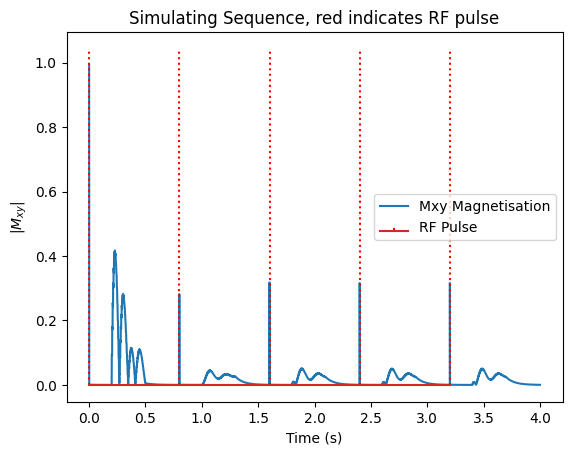

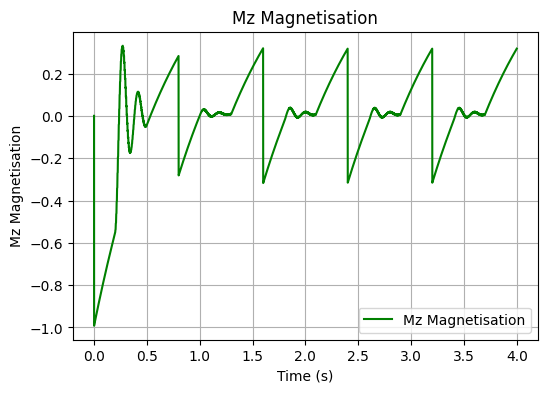

8000
Simulating TRs for visualisation...
(8000, 3)


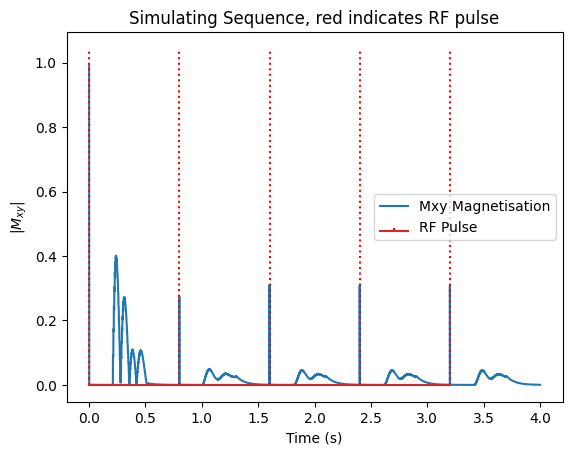

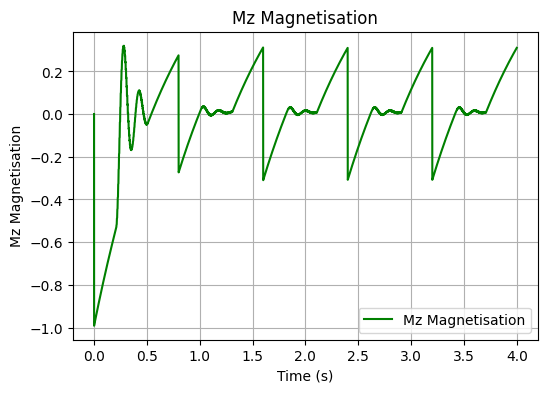

8000
Simulating TRs for visualisation...
(8000, 3)


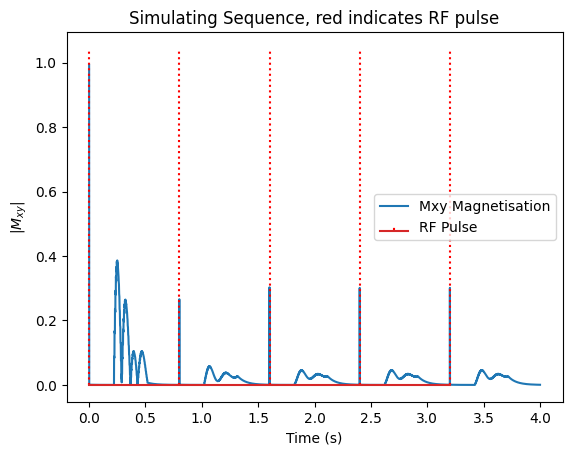

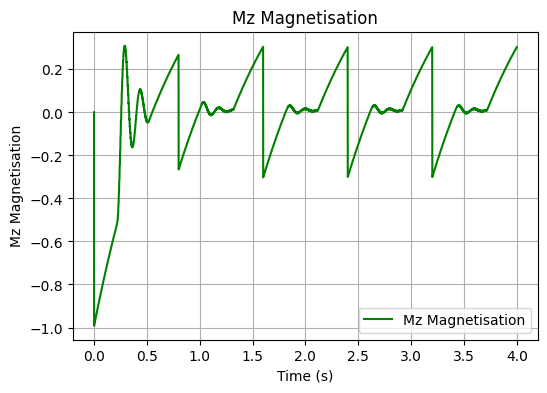

8000
Simulating TRs for visualisation...
(8000, 3)


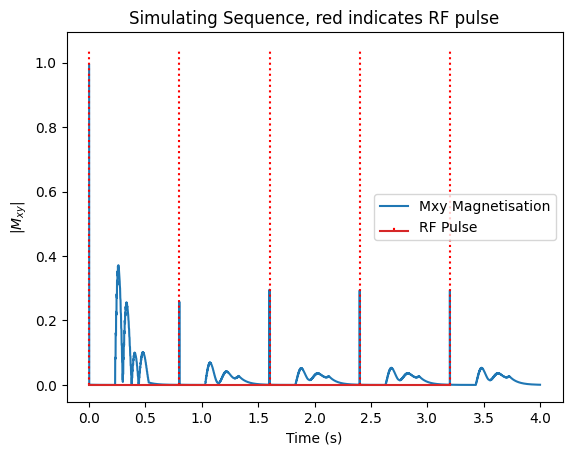

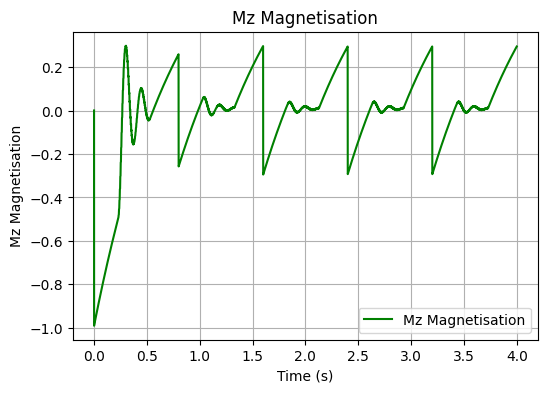

In [57]:
for i in t_i:
    lengt,M_measured,npts_tr_long,t_res = visual(i,t_tr_long,noTRvis)

    # Plot the x-y magnetisation over the whole simulation
    plt.plot(np.arange(0,(lengt))*t_res,np.abs(M_measured[:,0]+1j*M_measured[:,1]),label='Mxy Magnetisation');
    
    # Plot the RF pulses and adjust figure appearance
    yax=plt.gca().get_ylim();
    plt.stem(np.arange(0,noTRvis)*npts_tr_long*t_res,np.ones(noTRvis)*yax[1],':r',markerfmt=" ",label='RF Pulse')
    plt.xlabel('Time (s)');plt.ylabel('$|M_{xy}|$');plt.title('Simulating Sequence, red indicates RF pulse');
    # plt.ylim([0,1.2]);plt.xlim([0,1]);
    plt.legend()
    
    print(M_measured.shape)
    
    # Create a figure for Mz (Longitudinal Magnetization)
    plt.figure(figsize=(6, 4))
    plt.plot(np.arange(0, (lengt)) * t_res, M_measured[:, 2], label='Mz Magnetisation', color='green')
    plt.xlabel('Time (s)')
    plt.ylabel('Mz Magnetisation')
    plt.title('Mz Magnetisation')
    # plt.ylim([-1.2,1]);plt.xlim([309,max(np.arange(0, (lengt)) * t_res)]);
    plt.legend()
    plt.grid(True)
    plt.show()